In [1]:
from utils import *
from mnist_tasks.mnist_loader import train_set, test_set, valid_set
from torch.utils.data import DataLoader, random_split

Compose(
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
Train data set: 54000
Test data set: 10000
Valid data set: 6000


In [2]:
digits_to_store = [0,1]
MODE = "background"

spurious_p = 0.225
random_p = 1 - spurious_p

batch_size = 1280

store_dir = "/hdd2/dyah/coloredmnist_synthetic_spurious"
if not os.path.isdir(store_dir):
    os.makedirs(store_dir)

In [3]:
# divide train and valid sets into 90-10 splits: 90 random color, 10 spurious color that will be flipped in test
# flip the 10% color for test set
train_rnd_size, train_spur_size = int(len(train_set) * random_p), int(len(train_set) * spurious_p)
val_rnd_size, val_spur_size = int(len(valid_set) * random_p), int(len(valid_set) * spurious_p)

train_rnd_set, train_spur_set = random_split(train_set, [train_rnd_size, train_spur_size])
val_rnd_set, val_spur_set = random_split(valid_set, [val_rnd_size, val_spur_size])

train_rnd_loader = DataLoader(train_rnd_set, batch_size=batch_size, shuffle=False)
train_spur_loader = DataLoader(train_spur_set, batch_size=batch_size, shuffle=False)

val_rnd_loader = DataLoader(val_rnd_set, batch_size=batch_size, shuffle=False)
val_spur_loader = DataLoader(val_spur_set, batch_size=batch_size, shuffle=False)

0it [00:00, ?it/s]/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:40: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  imgs = imgs[mask,:,:,:]
/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:41: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  labels = labels[mask]
33it [02:28,  4.50s/it]


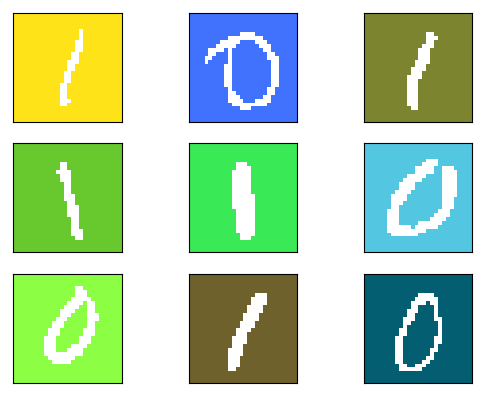

In [4]:
train_random_images, train_random_labels = transform_image_random(train_rnd_loader)
show_random_images(train_random_images)

In [5]:
train_metadata_rnd = save_images_and_get_metadata(train_random_images, train_random_labels, 
                                              "train_random", save_dir=os.path.join(store_dir, "train"))
train_metadata_rnd['split'] = [0 for i in range(len(train_metadata_rnd['label']))]
train_metadata_rnd['random'] = [1 for i in range(len(train_metadata_rnd['label']))]

In [6]:
# define the spurious environment
spurious_env = random_generator[MODE](digits_to_store)
flip_map = generate_random_flip_map()
spurious_env_flip = flip_digit_color(flip_map, spurious_env)

0it [00:00, ?it/s]/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  imgs = imgs[mask,:,:,:]
/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  labels = labels[mask]
1it [00:05,  5.44s/it]/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  imgs = imgs[mask,:,:,:]
/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:26: UserWarning: indexing with dtype torch.u

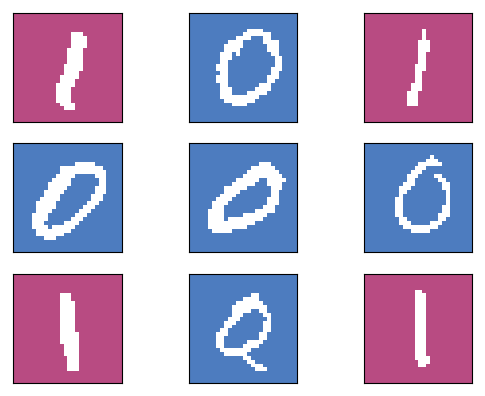

In [7]:
train_spur_images, train_spur_labels = transform_image_with_env(spurious_env, train_spur_loader)
show_random_images(train_spur_images)

In [8]:
train_metadata_spur = save_images_and_get_metadata(train_spur_images, train_spur_labels, 
                                              "train_spurious", 
                                                   save_dir=os.path.join(store_dir, "train"))
train_metadata_spur['split'] = [0 for i in range(len(train_metadata_spur['label']))]
train_metadata_spur['random'] = [0 for i in range(len(train_metadata_spur['label']))]

In [9]:
val_random_images, val_random_labels = transform_image_random(val_rnd_loader)
val_metadata_rnd = save_images_and_get_metadata(val_random_images, val_random_labels, 
                                              "val_random", save_dir=os.path.join(store_dir, "val"))
val_metadata_rnd['split'] = [2 for i in range(len(val_metadata_rnd['label']))]
val_metadata_rnd['random'] = [1 for i in range(len(val_metadata_rnd['label']))]

val_spur_images, val_spur_labels = transform_image_with_env(spurious_env, val_spur_loader)
val_metadata_spur = save_images_and_get_metadata(val_spur_images, val_spur_labels, 
                                              "val_spurious", save_dir=os.path.join(store_dir, "val"))
val_metadata_spur['split'] = [2 for i in range(len(val_metadata_spur['label']))]
val_metadata_spur['random'] = [0 for i in range(len(val_metadata_spur['label']))]

0it [00:00, ?it/s]/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:40: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  imgs = imgs[mask,:,:,:]
/hdd2/dyah/sicheng_test/comnivore/libs/synthetic_colored_mnist/utils.py:41: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  labels = labels[mask]
4it [00:17,  4.28s/it]
2it [00:04,  2.42s/it]


In [10]:
spurious_p_test = 0.7
random_p_test = 1 - spurious_p_test

In [11]:
test_rnd_size, test_spur_size = int(len(test_set) * random_p_test), int(len(test_set) * spurious_p_test)

In [12]:
test_rnd_set, test_spur_set = random_split(test_set, [test_rnd_size, test_spur_size])

In [13]:
test_rnd_loader = DataLoader(test_rnd_set, batch_size=batch_size, shuffle=False)
test_spur_loader = DataLoader(test_spur_set, batch_size=batch_size, shuffle=False)

In [14]:
test_random_images, test_random_labels = transform_image_random(test_rnd_loader)

3it [00:11,  3.74s/it]


In [15]:
test_metadata_rnd = save_images_and_get_metadata(test_random_images, test_random_labels, 
                                              "test_random", save_dir=os.path.join(store_dir, "test"))
test_metadata_rnd['split'] = [1 for i in range(len(test_metadata_rnd['label']))]
test_metadata_rnd['random'] = [1 for i in range(len(test_metadata_rnd['label']))]

In [16]:
test_spur_images, test_spur_labels = transform_image_with_env(spurious_env_flip, test_spur_loader)

6it [00:23,  3.98s/it]


In [17]:
test_metadata_spur = save_images_and_get_metadata(test_spur_images, test_spur_labels, 
                                              "test_spurious",save_dir=os.path.join(store_dir, "test"))
test_metadata_spur['split'] = [1 for i in range(len(test_metadata_spur['label']))]
test_metadata_spur['random'] = [0 for i in range(len(test_metadata_spur['label']))]

In [18]:
def merge_metadata(metadata_list):
    for i, metadata in enumerate(metadata_list):
        if i == 0:
            image_path = [path for path in metadata['image_path']]
            labels = [label for label in metadata['label']]
            splits = [split for split in metadata['split']]
            random = [rnd for rnd in metadata['random']]
        else:
            image_path.extend([path for path in metadata['image_path']])
            labels.extend([label for label in metadata['label']])
            splits.extend([split for split in metadata['split']])
            random.extend([rnd for rnd in metadata['random']])
    metadata_all = {'image_path': image_path}
    metadata_all['label'] = labels
    metadata_all['split'] = splits
    metadata_all['random'] = random
    return metadata_all

In [19]:
metadata_all = merge_metadata([train_metadata_rnd, train_metadata_spur, 
                              val_metadata_rnd, val_metadata_spur,
                              test_metadata_rnd, test_metadata_spur])

In [20]:
store_metadata(metadata_all, save_dir=store_dir)